In [1]:
import pandas as pd
import numpy as np
import nltk
import networkx as nx
import re
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer

In [2]:
df = pd.read_csv('the-office-lines (drive) - scripts.csv')
df_episode_full = pd.read_csv('The Office episode names2.csv')

In [3]:
df['line_text'] = df['line_text'].apply(lambda x: re.sub(r'\[.*?\]','', x))

In [4]:
df

,id,season,episode,scene,line_text,speaker,deleted
0,1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,False
1,2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False
2,3,1,1,1,So you've come to the master for guidance? Is ...,Michael,False
3,4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False
4,5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False
5,6,1,1,2,"Yes, I'd like to speak to your office manager...",Michael,False
6,7,1,1,3,"I've, uh, I've been at Dunder Mifflin for 12 y...",Michael,False
7,8,1,1,3,Well. I don't know.,Pam,False
8,9,1,1,3,"If you think she's cute now, you should have s...",Michael,False
9,10,1,1,3,What?,Pam,False


In [5]:
df_episode_full['title'] = df_episode_full['title'].str[1:-1]

df_episode_list = df_episode_full.drop(columns = 'date')

In [6]:
df = df[df['deleted']==False]
df = df.drop(columns = 'deleted')
df = df.reset_index(drop=True)
df['id'] = df.reset_index()

### Preprocess the text

In [7]:
# Text preprocessing steps - remove numbers, captial letters and punctuation
alphanumeric = lambda x: re.sub('\w*\d\w*', '', x)
special_char = lambda x: re.sub('�', '', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x.lower())

df['line_text'] = df.line_text.map(alphanumeric).map(special_char).map(punc_lower)

In [8]:
#lower case character names
lower = lambda x: x.lower()

df['speaker'] = df.speaker.map(lower)

# EDA

### getting # of character lines by season

In [56]:
df_char = pd.DataFrame(df.groupby(['season','speaker'])['line_text'].count()).reset_index()

In [57]:
df_char1 = df_char[df_char['season']==1].sort_values('line_text', ascending = False)
df_char2 = df_char[df_char['season']==2].sort_values('line_text', ascending = False)
df_char3 = df_char[df_char['season']==3].sort_values('line_text', ascending = False)
df_char4 = df_char[df_char['season']==4].sort_values('line_text', ascending = False)
df_char5 = df_char[df_char['season']==5].sort_values('line_text', ascending = False)
df_char6 = df_char[df_char['season']==6].sort_values('line_text', ascending = False)
df_char7 = df_char[df_char['season']==7].sort_values('line_text', ascending = False)
df_char8 = df_char[df_char['season']==8].sort_values('line_text', ascending = False)
df_char9 = df_char[df_char['season']==9].sort_values('line_text', ascending = False)

In [58]:
df_char1['line_perc'] = df_char1['line_text'] / df_char1['line_text'].sum()
df_char2['line_perc'] = df_char2['line_text'] / df_char2['line_text'].sum()
df_char3['line_perc'] = df_char3['line_text'] / df_char3['line_text'].sum()
df_char4['line_perc'] = df_char4['line_text'] / df_char4['line_text'].sum()
df_char5['line_perc'] = df_char5['line_text'] / df_char5['line_text'].sum()
df_char6['line_perc'] = df_char6['line_text'] / df_char6['line_text'].sum()
df_char7['line_perc'] = df_char7['line_text'] / df_char7['line_text'].sum()
df_char8['line_perc'] = df_char8['line_text'] / df_char8['line_text'].sum()
df_char9['line_perc'] = df_char9['line_text'] / df_char9['line_text'].sum()

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.lines as mlines
import matplotlib.style as style
style.available

style.use('fivethirtyeight')

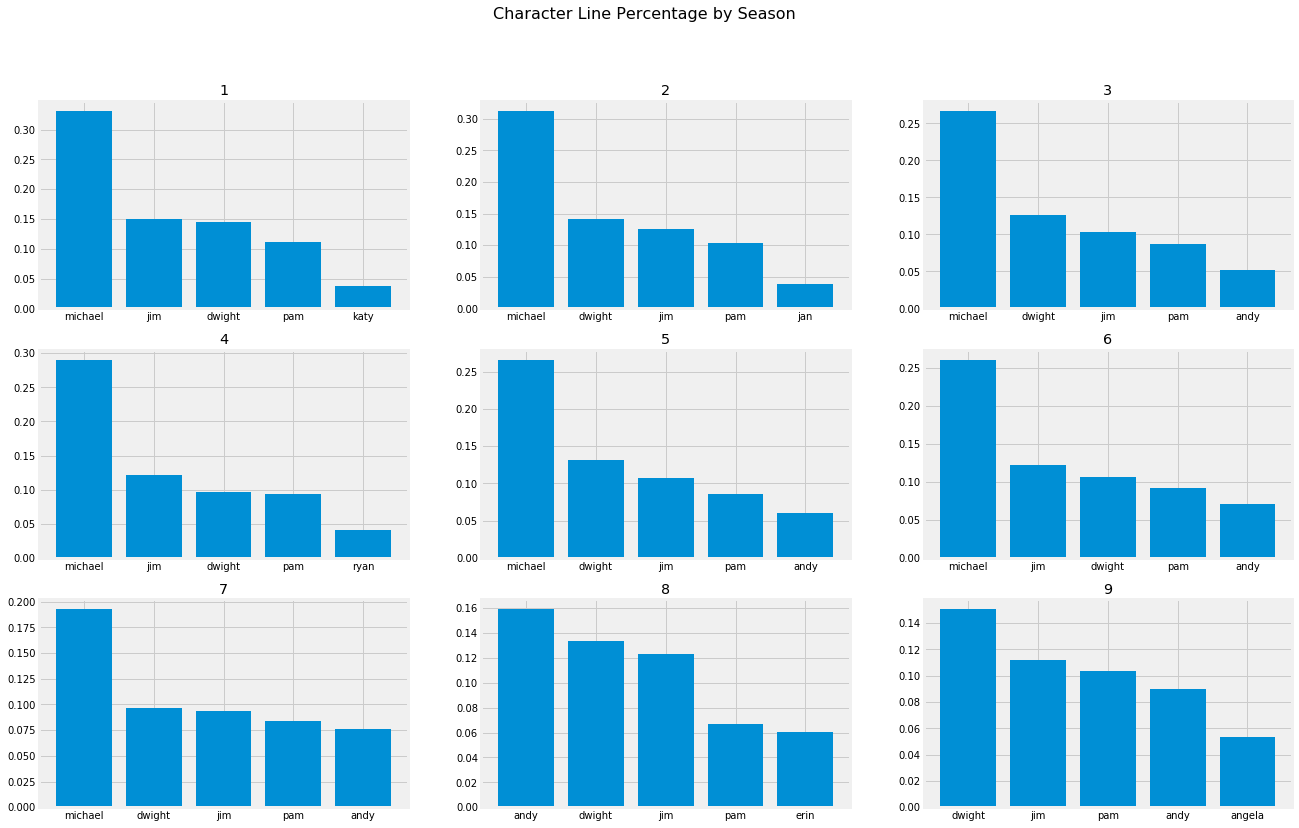

In [60]:
plt.figure(figsize=[20,13])

plt.suptitle('Character Line Percentage by Season',fontsize = 16)

plt.subplot(3,3,1) 
plt.bar(df_char1['speaker'].iloc[:5],df_char1['line_perc'].iloc[:5])
plt.title('1')
plt.subplot(3,3,2) 
plt.bar(df_char2['speaker'].iloc[:5],df_char2['line_perc'].iloc[:5])
plt.title('2')
plt.subplot(3,3,3) 
plt.bar(df_char3['speaker'].iloc[:5],df_char3['line_perc'].iloc[:5])
plt.title('3')
plt.subplot(3,3,4) 
plt.bar(df_char4['speaker'].iloc[:5],df_char4['line_perc'].iloc[:5])
plt.title('4')
plt.subplot(3,3,5) 
plt.bar(df_char5['speaker'].iloc[:5],df_char5['line_perc'].iloc[:5])
plt.title('5')
plt.subplot(3,3,6) 
plt.bar(df_char6['speaker'].iloc[:5],df_char6['line_perc'].iloc[:5])
plt.title('6')
plt.subplot(3,3,7) 
plt.bar(df_char7['speaker'].iloc[:5],df_char7['line_perc'].iloc[:5])
plt.title('7')
plt.subplot(3,3,8) 
plt.bar(df_char8['speaker'].iloc[:5],df_char8['line_perc'].iloc[:5])
plt.title('8')
plt.subplot(3,3,9) 
plt.bar(df_char9['speaker'].iloc[:5],df_char9['line_perc'].iloc[:5])
plt.title('9');

### Total lines by char

In [61]:
df_char_total = pd.DataFrame(df['speaker'].value_counts(normalize=True)).reset_index()
df_char_total['line_count'] = list(df['speaker'].value_counts())
df_char_total.columns = ['speaker','line_percent','line_count']

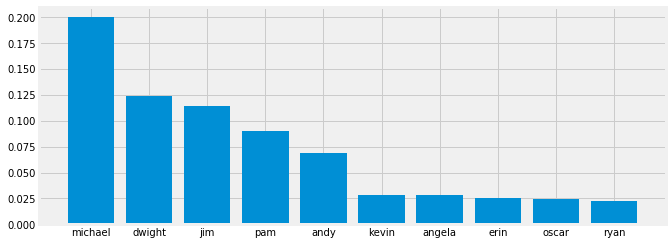

In [62]:
plt.figure(figsize=[10,4])
plt.bar(df_char_total['speaker'].iloc[:10],df_char_total['line_percent'].iloc[:10]);

In [63]:
# df_char_total

# Relationship by scenes (Building Character Webs)

In [118]:
df_matrix = pd.DataFrame(df[df['season']==9].groupby(['episode','scene'])['speaker'].unique()).reset_index()

In [119]:
characters = ['michael',
 'dwight',
 'jim',
 'pam',
 'andy',
 'kevin',
 'angela',
 'oscar',
 'ryan',
 'darryl',
 'phyllis',
 'kelly',
 'jan',
 'toby']

In [120]:
#--> iterate through each and store in dictionary
scene_dictionary = {}
iterative = 0
for scene in df_matrix.speaker:
    iterative += 1
    for char in characters:
        if char in scene:
            if str(iterative) in scene_dictionary.keys():
                scene_dictionary[str(iterative)].append(char)  
            else:
                scene_dictionary[str(iterative)] = [char]        

In [121]:
##set base df (co-occurance matrix)
df_co = pd.DataFrame(columns = characters, index = characters)
df_co[:] = int(0)

#iterate through each POV of book and add one for each character-character relationship
#-> in this case, relationship equates to appearing in the same POV
for value in scene_dictionary.values():
    for character1 in characters:
        for character2 in characters:
            if character1 in value and character2 in value:
                df_co[character1][character2] += 1
#                 df_co[character2][character1] += 1

In [122]:
df_co

,michael,dwight,jim,pam,andy,kevin,angela,oscar,ryan,darryl,phyllis,kelly,jan,toby
michael,2,1,1,0,0,0,0,0,0,0,0,0,0,0
dwight,1,333,73,65,30,32,53,41,0,27,25,1,3,9
jim,1,73,243,99,21,21,17,19,0,30,20,0,0,6
pam,0,65,99,246,25,22,32,25,0,15,22,0,3,7
andy,0,30,21,25,182,24,17,24,0,30,24,0,1,10
kevin,0,32,21,22,24,132,46,44,0,14,27,1,0,5
angela,0,53,17,32,17,46,134,60,0,5,22,0,0,4
oscar,0,41,19,25,24,44,60,145,0,13,28,0,0,9
ryan,0,0,0,0,0,0,0,0,6,0,0,4,0,0
darryl,0,27,30,15,30,14,5,13,0,116,11,0,0,6


In [123]:
#add weights to edges
edge_list = [] #test networkx
for index, row in df_co.iterrows():
    i = 0
    for col in row:
        weight = float(col)/333
        edge_list.append((index, df_co.columns[i], weight))
        i += 1

# #Remove edge if 0.0
# updated_edge_list = [x for x in edge_list]
updated_edge_list = [x for x in edge_list if not x[2] == 0.0]

#create duple of char, occurance in novel
node_list = []
for i in characters:
    for e in updated_edge_list:
        if i == e[0] and i == e[1]:
           node_list.append((i, e[2]*6))
for i in node_list:
    if i[1] == 0.0:
        node_list.remove(i)

#remove self references
for i in updated_edge_list:
    if i[0] == i[1]:
        updated_edge_list.remove(i)

In [124]:
# nx.nodes(G)

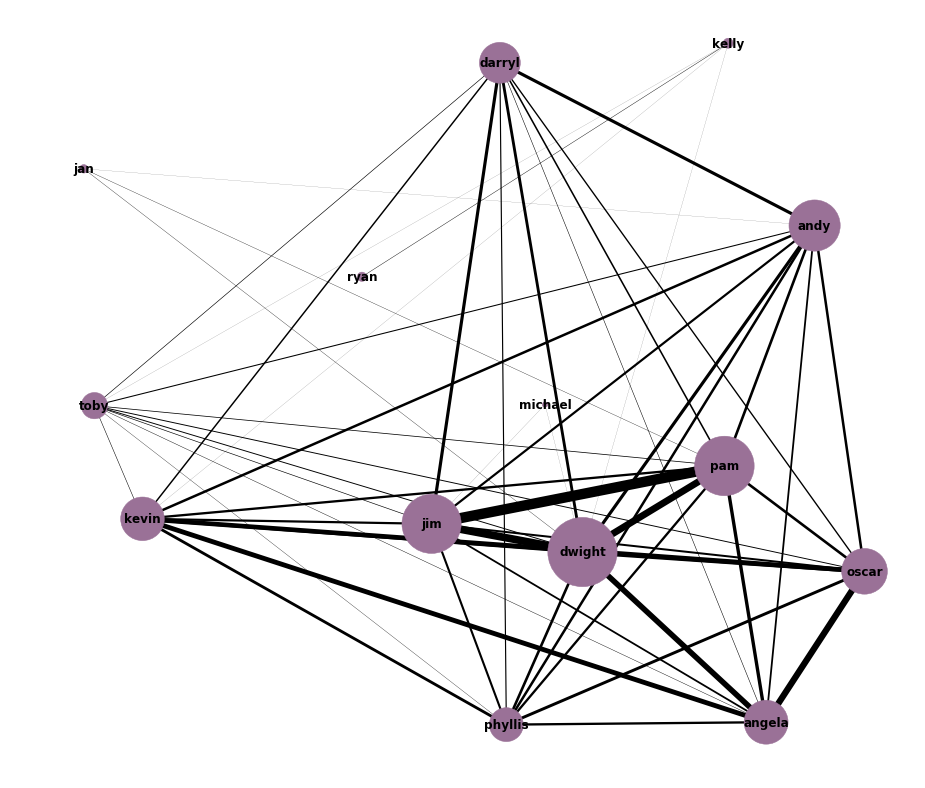

In [125]:
#set canvas size
plt.subplots(figsize=(14,14))

#networkx graph time!
G = nx.Graph()
for i in sorted(node_list):
    G.add_node(i[0], size = i[1])
G.add_weighted_edges_from(updated_edge_list)

#check data of graphs
#G.nodes(data=True)
#G.edges(data = True)

#manually copy and pasted the node order using 'nx.nodes(G)'
#Couldn't determine another route to listing out the order of nodes for future work
node_order = ['andy', 'angela', 'darryl', 'dwight', 'jan', 'jim', 'kelly', 
              'kevin', 'michael', 'oscar', 'pam', 'phyllis', 'ryan', 'toby']

#reorder node list
updated_node_order = []
for i in node_order:
    for x in node_list:
        if x[0] == i:
            updated_node_order.append(x)
            
#reorder edge list - this was a pain
test = nx.get_edge_attributes(G, 'weight')
updated_again_edges = []
for i in nx.edges(G):
    for x in iter(test.keys()):
        if i[0] == x[0] and i[1] == x[1]:
            updated_again_edges.append(test[x])
        

#drawing custimization
node_scalar = 800
edge_scalar = 35
sizes = [x[1]*node_scalar for x in updated_node_order]
widths = [x*edge_scalar for x in updated_again_edges]

#draw the graph

# pos = nx.spring_layout(G, k=0.42, iterations=25, seed = 10)

fixed_positions = {'angela': ( 0.47922707, -0.87824696),
 'darryl': (-0.01977077,  0.94596541),
 'dwight': ( 0.13507917, -0.40754861),
 'jan': (-0.79959829,  0.65262259),
 'jim': (-0.1477596 , -0.32948751),
 'kelly': (0.40816973, 1.        ),
 'kevin': (-0.68955929, -0.31563059),
 'michael': (0.06487521, 0.0004905 ),
 'oscar': ( 0.66366137, -0.46083924),
 'pam': ( 0.40105871, -0.16941619),
 'phyllis': (-0.00764334, -0.88498988),
 'ryan': (-0.27824627,  0.35394112),
 'toby': (-0.77960857, -0.00253779),
 'andy': (0.57011487, 0.49567716)}#dict with two of the positions set
fixed_nodes = fixed_positions.keys()
# pos = nx.spring_layout(G,pos=fixed_positions)
pos = nx.spring_layout(G,pos=fixed_positions, fixed = fixed_nodes)

nx.draw(G, pos, node_color = '#9A7197', with_labels=True, font_size = 12, font_weight = 'bold', 
        node_size = sizes, width = widths, seed = 10)

#plt.axis('off')
# plt.savefig("web9.png") # save as png